In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings 
warnings.filterwarnings('ignore')

In [2]:
def parser(x):
    return pd.datetime.strptime(x,'%Y-%m-%d')

In [3]:
dataset = pd.read_csv('birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [5]:
dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

1. Plot dataset birth.csv

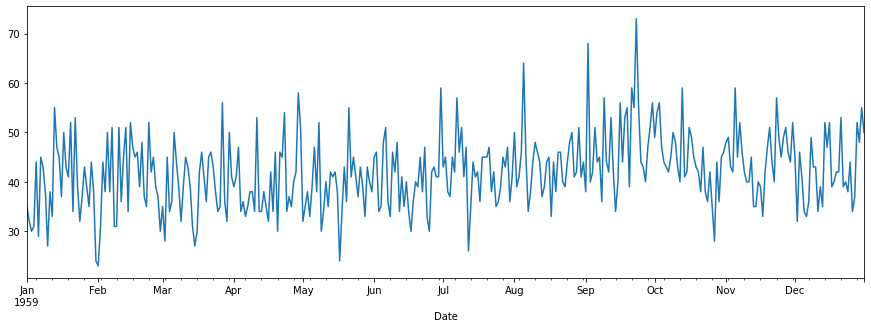

In [6]:
dataset.plot(figsize=(15,5))
plt.show()

2. Dari hasil plot tersebut tidak ditemukan adanya trend maupun seasonality.

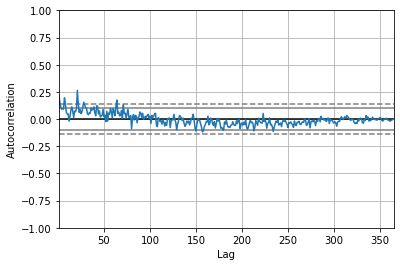

In [7]:
pd.plotting.autocorrelation_plot(dataset)
plt.show()

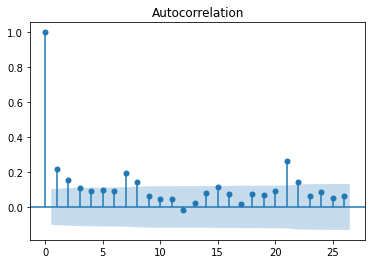

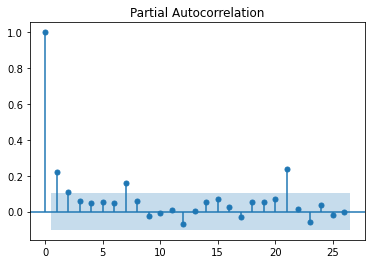

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(dataset)
plot_pacf(dataset)
plt.show()

In [9]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [11]:
model = ARIMA(dataset, order=(3,2,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D2.Births   No. Observations:                  363
Model:                 ARIMA(3, 2, 0)   Log Likelihood               -1340.435
Method:                       css-mle   S.D. of innovations              9.695
Date:                Thu, 17 Sep 2020   AIC                           2690.870
Time:                        21:31:42   BIC                           2710.342
Sample:                    01-03-1959   HQIC                          2698.610
                         - 12-31-1959                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0040      0.152      0.026      0.979      -0.295       0.303
ar.L1.D2.Births    -1.1421      0.049    -23.451      0.000      -1.238      -1.047
ar.L2.D2.Births    -0.8347      

C:\Users\0974\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\0974\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


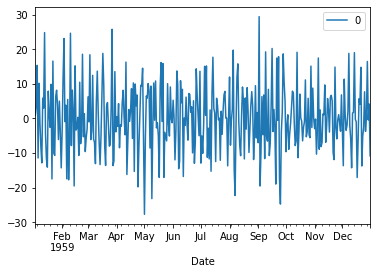

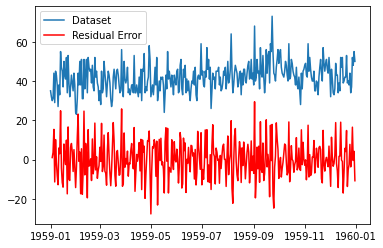

In [12]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

plt.plot(dataset)
plt.plot(residuals,  color='red')
plt.legend(['Dataset','Residual Error'])

In [13]:
residuals

,0
Date,
1959-01-03,0.995984
1959-01-04,3.648251
1959-01-05,15.357600
1959-01-06,-11.430069
1959-01-07,10.149221
...,...
1959-12-27,0.266775
1959-12-28,16.476512
1959-12-29,-0.453984


In [14]:
print(residuals.describe())

                0
count  363.000000
mean     0.025026
std      9.713923
min    -27.719612
25%     -6.367203
50%     -0.518666
75%      6.578204
max     29.438652


predicted=52.680576, expected=42.000000
predicted=41.355418, expected=34.000000
predicted=36.174486, expected=40.000000
predicted=35.545252, expected=56.000000
predicted=47.456476, expected=44.000000
predicted=50.397476, expected=53.000000
predicted=57.776837, expected=55.000000
predicted=58.084325, expected=39.000000
predicted=41.748884, expected=59.000000
predicted=55.191578, expected=55.000000
predicted=54.873356, expected=73.000000
predicted=72.330654, expected=55.000000
predicted=69.700951, expected=44.000000
predicted=46.868749, expected=43.000000
predicted=37.914446, expected=40.000000
predicted=28.270806, expected=47.000000
predicted=40.586599, expected=51.000000
predicted=50.997875, expected=56.000000
predicted=58.783974, expected=49.000000
predicted=55.940248, expected=54.000000
predicted=54.786427, expected=56.000000
predicted=55.946850, expected=47.000000
predicted=48.649113, expected=44.000000
predicted=44.207746, expected=43.000000
predicted=38.736382, expected=42.000000


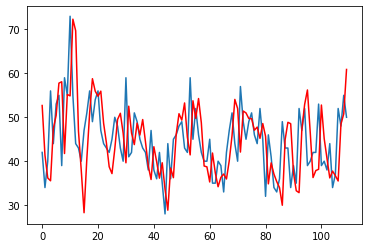

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

values = dataset.values
size = int(len(values) * 0.7)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(3,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    prediction = output[0]
    predictions.append(prediction)
    expected = test[t]
    history.append(expected)
    print('predicted=%f, expected=%f' % (prediction, expected))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.2f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [18]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = sqrt(mean_squared_error(test, predictions))
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [19]:
p_values = range(0, 10)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=8.189
ARIMA(0, 0, 1) RMSE=7.884
ARIMA(0, 0, 2) RMSE=7.771
ARIMA(0, 1, 0) RMSE=9.167
ARIMA(0, 1, 1) RMSE=7.527
ARIMA(0, 1, 2) RMSE=7.434
ARIMA(0, 2, 0) RMSE=15.698
ARIMA(0, 2, 1) RMSE=9.201
ARIMA(0, 2, 2) RMSE=7.551
ARIMA(1, 0, 0) RMSE=7.802
ARIMA(1, 0, 1) RMSE=7.554
ARIMA(1, 1, 0) RMSE=8.120
ARIMA(1, 1, 1) RMSE=7.425
ARIMA(1, 1, 2) RMSE=7.429
ARIMA(1, 2, 0) RMSE=11.990
ARIMA(2, 0, 0) RMSE=7.697
ARIMA(2, 0, 1) RMSE=7.421
ARIMA(2, 0, 2) RMSE=7.481
ARIMA(2, 1, 0) RMSE=7.713
ARIMA(2, 1, 1) RMSE=7.417
ARIMA(2, 1, 2) RMSE=7.431
ARIMA(2, 2, 0) RMSE=10.373
ARIMA(3, 0, 0) RMSE=7.693
ARIMA(3, 0, 1) RMSE=7.447
ARIMA(3, 0, 2) RMSE=7.477
ARIMA(3, 1, 0) RMSE=7.581
ARIMA(3, 1, 1) RMSE=7.456
ARIMA(3, 1, 2) RMSE=7.505
ARIMA(3, 2, 0) RMSE=9.474
ARIMA(4, 0, 0) RMSE=7.693
ARIMA(4, 0, 1) RMSE=7.825
ARIMA(4, 0, 2) RMSE=7.426
ARIMA(4, 1, 0) RMSE=7.578
ARIMA(4, 1, 1) RMSE=7.474
ARIMA(4, 1, 2) RMSE=7.455
ARIMA(4, 2, 0) RMSE=8.956
ARIMA(5, 0, 0) RMSE=7.676
ARIMA(5, 0, 1) RMSE=7.647
ARIMA(5, 

3. Hasil parameter tuning terbaik untuk ARIMA diperoleh pada nilai p, d, q = (6, 1, 0) dengan nilai RMSE sebesar 7.29. Nilai tersebut lebih kecil dibandingkan parameter p, d, dan q yang lain.

SARIMAX

In [20]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [21]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [ ]:
n_test = 12

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

4. Hasil terbaik dari parameter tuning SARIMAX belum dapat diketahui karna waktu processing yang sangat lama.